Loaded 8,742 rows, 94 columns
Non-NaN counts:
  ComplianceDim_structure_validity: 8,742
  Compliance_Score:   8,742

Rows per Method:
Method
Direct (Non-Reasoning)    2394
Prompt2DAG (Template)     1578
Prompt2DAG (LLM)          2043
Prompt2DAG (Hybrid)       2043
Direct (Reasoning)         684
Name: count, dtype: int64

Corr(Combined, ORT_capped):
                Combined_Score  ORT_capped
Combined_Score           1.000       0.702
ORT_capped               0.702       1.000
Rows with both structure + platform: 8742

Category counts:
StructPlat_Category
Mixed                  3459
LowStruct_LowPlat      3419
HighStruct_HighPlat    1815
LowStruct_HighPlat       49
Name: count, dtype: int64
TABLE R1: Run-level means by Struct×Platform regime (all methods)
                     ComplianceDim_structure_validity  Compliance_Score  Static_Score  Combined_Score  ORT_capped  Total_Issues  Critical_Issues  Major_Issues  Minor_Issues  N_runs    Pass%
StructPlat_Category                           

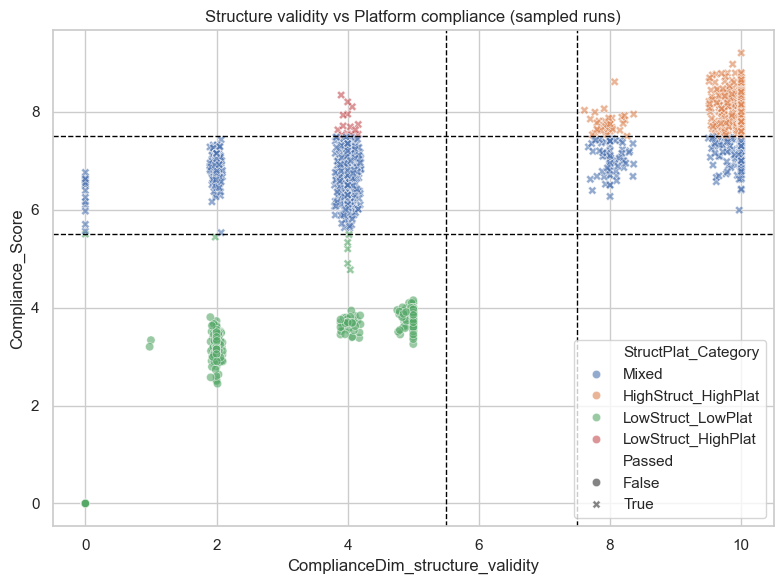

TABLE P7: Pipeline-level frequency of mismatch regimes (LowStruct_HighPlat / HighStruct_LowPlat)
                                                                                         Pipeline_ID StructPlat_Category  N_runs  N_total_runs  Frac%  Pass%   ORT  Combined  Struct  Plat
         synthetic-generator-v2__synthetic_staged_etl_00_healthcare_claims_processing.py_description  LowStruct_HighPlat       4           234    1.7  100.0 3.540     7.352   4.062 7.890
                                                   peterbull__bodhi-cast__log_cleanup.py_description  LowStruct_HighPlat       3           213    1.4  100.0 1.957     6.967   4.050 7.623
             synthetic-generator-v2__synthetic_branch_merge_01_fraud_detection_triage.py_description  LowStruct_HighPlat       3           234    1.3  100.0 1.910     7.197   4.017 7.607
           synthetic-generator-v2__synthetic_branch_merge_03_regulatory_report_router.py_description  LowStruct_HighPlat       3           234    1.3  100.

In [1]:
# %% [markdown]
# # Structural validity vs Platform compliance regimes (with ORT + pipeline metadata)
#
# **Goal**
# Investigate cases where:
# - Platform compliance is high but DAG structure validity drops (LowStruct_HighPlat)
# - DAG structure validity is high but platform compliance drops (HighStruct_LowPlat)
#
# We:
# 1) Create 4 regimes based on thresholds:
#    - HighStruct_HighPlat
#    - LowStruct_HighPlat  (reviewer counterexamples)
#    - LowStruct_LowPlat
#    - HighStruct_LowPlat  (often rare)
# 2) Summarize by:
#    - overall (run-level)
#    - Method × regime
#    - Orchestrator × regime
#    - Method × Orchestrator × regime (compact)
# 3) Pipeline-level: find pipelines that frequently produce these counterexamples.
# 4) Show representative examples (top/bottom) with metadata.
#
# Uses: all_sessions_cleaned.csv (NOT consolidated_results.csv)

# %%
import json
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(style="whitegrid")
pd.set_option("display.max_columns", 220)
pd.set_option("display.width", 240)

# %% [markdown]
# ## 0) Paths + key parameters

# %%
CSV_PATH = "/Users/abubakarialidu/Desktop/Data Result/all_sessions_cleaned.csv"
META_JSON_PATH = "/Users/abubakarialidu/Desktop/Data Result/pipeline_analysis_results/pipeline_analysis_complete.json"

# Regime thresholds (tune if needed)
HIGH_THR = 7.5
LOW_THR  = 5.5

STRUCT_COL = "ComplianceDim_structure_validity"  # structural validity of DAG
PLAT_COL   = "Compliance_Score"                 # overall platform compliance

# ORT weights (match your main analysis)
ALPHA_CRIT = 2.0
BETA_MAJOR = 1.0
GAMMA_MINOR = 0.25

METHOD_ORDER = [
    "Direct (Non-Reasoning)",
    "Prompt2DAG (Template)",
    "Prompt2DAG (LLM)",
    "Prompt2DAG (Hybrid)",
    "Direct (Reasoning)",
]
ORCH_ORDER = ["airflow", "dagster", "prefect"]

# How many representative examples to show in printed tables
TOP_K = 10

# %% [markdown]
# ## 1) Load data + sanity check required columns

# %%
df = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df):,} rows, {len(df.columns)} columns")

required = [
    "Pipeline_ID", "Workflow", "Strategy", "Orchestrator", "Passed",
    "Static_Score", "Compliance_Score", "Combined_Score",
    STRUCT_COL
]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df["Orchestrator"] = df["Orchestrator"].astype(str).str.lower().str.strip()
if df["Passed"].dtype != bool:
    df["Passed"] = df["Passed"].astype(str).str.lower().map({"true": True, "false": False, "1": True, "0": False})

print("Non-NaN counts:")
print(f"  {STRUCT_COL}: {df[STRUCT_COL].notna().sum():,}")
print(f"  {PLAT_COL}:   {df[PLAT_COL].notna().sum():,}")

# %% [markdown]
# ## 2) 5-method classification (same as your main analysis)

# %%
def classify_method(row):
    workflow = row.get("Workflow", "")
    strategy = str(row.get("Strategy") or "").lower()
    if workflow == "Direct":
        return "Direct (Non-Reasoning)"
    elif workflow == "Reasoning":
        return "Direct (Reasoning)"
    elif workflow == "Prompt2DAG":
        if "template" in strategy:
            return "Prompt2DAG (Template)"
        elif "llm" in strategy:
            return "Prompt2DAG (LLM)"
        elif "hybrid" in strategy:
            return "Prompt2DAG (Hybrid)"
        else:
            return f"Prompt2DAG ({row.get('Strategy','Unknown')})"
    return workflow

df["Method"] = df.apply(classify_method, axis=1)
df = df[df["Method"].isin(METHOD_ORDER)].copy()

print("\nRows per Method:")
print(df["Method"].value_counts().reindex(METHOD_ORDER))

# %% [markdown]
# ## 3) Compute ORT (capped 0–10) consistent with the regime analysis goal
#
# For this regime analysis, it’s often clearer to use ORT *capped* (0–10) rather than scaled.
# (Scaled is fine too, but capped is directly interpretable and stable.)

# %%
for c in ["Critical_Issues", "Major_Issues", "Minor_Issues"]:
    if c not in df.columns:
        df[c] = 0
    df[c] = df[c].fillna(0)

df["Total_Issues"] = df["Critical_Issues"] + df["Major_Issues"] + df["Minor_Issues"]

df["Base_Score"] = np.where(df["Passed"] == True, df["Combined_Score"], 0.0)
df["Penalty"] = (
    ALPHA_CRIT * df["Critical_Issues"]
    + BETA_MAJOR * df["Major_Issues"]
    + GAMMA_MINOR * df["Minor_Issues"]
)
df["ORT_raw"] = df["Base_Score"] - df["Penalty"]
df["ORT_capped"] = df["ORT_raw"].clip(lower=0.0, upper=10.0)

print("\nCorr(Combined, ORT_capped):")
print(df[["Combined_Score","ORT_capped"]].corr().round(3).to_string())

# %% [markdown]
# ## 4) Define the 4 regimes: structure × platform

# %%
df_sp = df.dropna(subset=[STRUCT_COL, PLAT_COL]).copy()
print("Rows with both structure + platform:", len(df_sp))

def classify_struct_plat(s, p, high_thr=HIGH_THR, low_thr=LOW_THR):
    high_s = s >= high_thr
    low_s  = s <= low_thr
    high_p = p >= high_thr
    low_p  = p <= low_thr

    if high_s and high_p:
        return "HighStruct_HighPlat"
    if low_s and high_p:
        return "LowStruct_HighPlat"
    if low_s and low_p:
        return "LowStruct_LowPlat"
    if high_s and low_p:
        return "HighStruct_LowPlat"
    return "Mixed"

df_sp["StructPlat_Category"] = df_sp.apply(lambda r: classify_struct_plat(r[STRUCT_COL], r[PLAT_COL]), axis=1)

print("\nCategory counts:")
print(df_sp["StructPlat_Category"].value_counts())

# %% [markdown]
# ## 5) Run-level summary per category (overall)
#
# This is a compact “Table D1” analog for the paper appendix.

# %%
summary_cols = [
    STRUCT_COL, PLAT_COL,
    "Static_Score", "Compliance_Score", "Combined_Score",
    "ORT_capped",
    "Total_Issues", "Critical_Issues", "Major_Issues", "Minor_Issues",
    "Passed"
]

cat_summary = (
    df_sp
    .groupby("StructPlat_Category")[summary_cols]
    .agg({
        STRUCT_COL: "mean",
        PLAT_COL: "mean",
        "Static_Score":"mean",
        "Compliance_Score":"mean",
        "Combined_Score":"mean",
        "ORT_capped":"mean",
        "Total_Issues":"mean",
        "Critical_Issues":"mean",
        "Major_Issues":"mean",
        "Minor_Issues":"mean",
        "Passed":"mean"
    })
    .rename(columns={"Passed":"Pass_Rate"})
)

counts = df_sp["StructPlat_Category"].value_counts().rename("N_runs")
cat_summary = cat_summary.join(counts, how="left")
cat_summary["Pass%"] = 100*cat_summary["Pass_Rate"]
cat_summary = cat_summary.drop(columns=["Pass_Rate"]).round(3)

print("="*120)
print("TABLE R1: Run-level means by Struct×Platform regime (all methods)")
print("="*120)
print(cat_summary.to_string())

# %% [markdown]
# ## 6) Where do these regimes come from? (Method × regime, Orchestrator × regime)
#
# These tables answer:
# - Is LowStruct_HighPlat mainly a Prompt2DAG phenomenon? (it often is)
# - Is it orchestrator-specific?
#
# We report both frequency and mean ORT.

# %%
def regime_breakdown(group_cols):
    tmp = (
        df_sp
        .groupby(group_cols + ["StructPlat_Category"], observed=True)
        .agg(
            N=("Pipeline_ID", "size"),
            Pass_Rate=("Passed","mean"),
            ORT=("ORT_capped","mean"),
            Combined=("Combined_Score","mean"),
            Struct=("ComplianceDim_structure_validity","mean"),
            Plat=("Compliance_Score","mean"),
        )
        .reset_index()
    )
    tmp["Pass%"] = (100*tmp["Pass_Rate"]).round(1)
    tmp["ORT"] = tmp["ORT"].round(2)
    tmp["Combined"] = tmp["Combined"].round(2)
    tmp = tmp.drop(columns=["Pass_Rate"])
    return tmp.sort_values(group_cols + ["StructPlat_Category"])

print("\n" + "="*120)
print("TABLE R2: Method × Regime (run-level)")
print("="*120)
print(regime_breakdown(["Method"]).to_string(index=False))

print("\n" + "="*120)
print("TABLE R3: Orchestrator × Regime (run-level)")
print("="*120)
print(regime_breakdown(["Orchestrator"]).to_string(index=False))

# Compact 3D view for appendix diagnostics
print("\n" + "="*120)
print("TABLE R4: Orchestrator × Method × Regime (run-level; compact metrics)")
print("="*120)
r4 = regime_breakdown(["Orchestrator","Method"])
print(r4[["Orchestrator","Method","StructPlat_Category","N","Pass%","ORT","Combined","Struct","Plat"]].to_string(index=False))

# %% [markdown]
# ## 7) Visual: scatter of Structure vs Platform compliance
#
# This gives an intuitive picture for reviewers.

# %%
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_sp.sample(min(2500, len(df_sp)), random_state=42),
    x=STRUCT_COL, y=PLAT_COL,
    hue="StructPlat_Category",
    style="Passed",
    alpha=0.6
)
plt.axvline(LOW_THR, color="black", linestyle="--", linewidth=1)
plt.axvline(HIGH_THR, color="black", linestyle="--", linewidth=1)
plt.axhline(LOW_THR, color="black", linestyle="--", linewidth=1)
plt.axhline(HIGH_THR, color="black", linestyle="--", linewidth=1)
plt.title("Structure validity vs Platform compliance (sampled runs)")
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 8) Pipeline-level analysis: which pipelines generate LowStruct_HighPlat (and vice versa)?
#
# Instead of listing all pipelines, we compute per pipeline:
# - fraction of runs in each regime
# - mean ORT / pass rate in that regime
#
# This tells you:
# - whether “counterexamples” are concentrated in a few pipelines or widespread.

# %%
pipe_regime = (
    df_sp
    .groupby(["Pipeline_ID","StructPlat_Category"], observed=True)
    .agg(
        N_runs=("Passed","size"),
        Pass_Rate=("Passed","mean"),
        ORT=("ORT_capped","mean"),
        Combined=("Combined_Score","mean"),
        Struct=("ComplianceDim_structure_validity","mean"),
        Plat=("Compliance_Score","mean")
    )
    .reset_index()
)

# total runs per pipeline (in df_sp)
pipe_tot = df_sp.groupby("Pipeline_ID").size().rename("N_total_runs").reset_index()

pipe_regime = pipe_regime.merge(pipe_tot, on="Pipeline_ID", how="left")
pipe_regime["Frac_of_pipeline"] = pipe_regime["N_runs"] / pipe_regime["N_total_runs"]

# focus on the two "mismatch" regimes
mismatch = pipe_regime[pipe_regime["StructPlat_Category"].isin(["LowStruct_HighPlat","HighStruct_LowPlat"])].copy()
mismatch["Pass%"] = (100*mismatch["Pass_Rate"]).round(1)
mismatch["Frac%"] = (100*mismatch["Frac_of_pipeline"]).round(1)

print("="*120)
print("TABLE P7: Pipeline-level frequency of mismatch regimes (LowStruct_HighPlat / HighStruct_LowPlat)")
print("="*120)
print(
    mismatch.sort_values(["StructPlat_Category","Frac_of_pipeline"], ascending=[True, False])
            [["Pipeline_ID","StructPlat_Category","N_runs","N_total_runs","Frac%","Pass%","ORT","Combined","Struct","Plat"]]
            .head(30)
            .round(3)
            .to_string(index=False)
)

# %% [markdown]
# ## 9) Add metadata to the pipeline-level mismatch table (domain/topology/complexity)
#
# This provides paper-friendly interpretation without listing everything.

# %%
# Load minimal metadata columns (optional; will still run without metadata)
if Path(META_JSON_PATH).exists():
    with open(META_JSON_PATH, "r", encoding="utf-8") as f:
        meta_json = json.load(f)

    meta_records = []
    for e in meta_json.get("analyses", []):
        src = e.get("source_file", "")
        pid = src.replace(".txt", "")
        topo = e.get("topology", {}) or {}
        comp = e.get("complexity", {}) or {}
        ext  = e.get("external_services", {}) or {}

        # Use standard_complexity_score if present
        std_c = comp.get("standard_complexity_score", None)
        raw_c = comp.get("complexity_score", None)
        use_c = std_c if std_c is not None else raw_c

        meta_records.append({
            "Pipeline_ID": pid,
            "pipeline_name": e.get("pipeline_name", pid),
            "domain_category": e.get("domain_category"),
            "topology_pattern": topo.get("pattern"),
            "parallelization_level": topo.get("parallelization_level"),
            "has_sensors": topo.get("has_sensors"),
            "has_branches": topo.get("has_branches"),
            "integration_pattern": ext.get("service_integration_pattern"),
            "std_complexity": use_c
        })
    df_meta = pd.DataFrame(meta_records)
else:
    df_meta = pd.DataFrame(columns=["Pipeline_ID"])

mismatch_meta = mismatch.merge(df_meta, on="Pipeline_ID", how="left")

print("="*120)
print("TABLE P8: Mismatch regimes with metadata (top 30 by fraction within pipeline)")
print("="*120)
print(
    mismatch_meta.sort_values(["StructPlat_Category","Frac_of_pipeline"], ascending=[True, False])
                [["Pipeline_ID","pipeline_name","domain_category","topology_pattern","parallelization_level",
                  "has_sensors","has_branches","integration_pattern","std_complexity",
                  "StructPlat_Category","Frac%","N_runs","N_total_runs","Pass%","ORT","Struct","Plat"]]
                .head(30)
                .round(3)
                .to_string(index=False)
)

# %% [markdown]
# ## 10) Representative run-level counterexamples with full context
#
# Reviewers usually want concrete examples.
# We will show:
# - Top K worst structure among High platform (LowStruct_HighPlat)
# - Top K worst platform among High structure (HighStruct_LowPlat) if any
#
# We include: Pipeline_ID, Method, Orchestrator, key compliance dims, ORT, issues.

# %%
def sample_examples(df_sub, n=TOP_K, sort_by=None, ascending=True):
    if sort_by is not None and sort_by in df_sub.columns:
        df_sub = df_sub.sort_values(sort_by, ascending=ascending)

    cols = [
        "Pipeline_ID", "Method", "Workflow", "Orchestrator", "Strategy",
        STRUCT_COL, "Compliance_Score",
        "ComplianceDim_loadability", "ComplianceDim_executability",
        "ComplianceDim_configuration_validity", "ComplianceDim_task_validity",
        "Static_Score", "Combined_Score", "ORT_capped",
        "Total_Issues", "Critical_Issues", "Major_Issues", "Minor_Issues",
        "Grade", "Passed"
    ]
    cols = [c for c in cols if c in df_sub.columns]
    return df_sub[cols].head(n).round(3)

# LowStruct_HighPlat examples: sort by structure ascending (worst structure first)
lshp = df_sp[df_sp["StructPlat_Category"] == "LowStruct_HighPlat"].copy()
print("="*120)
print("RUN EXAMPLES: LowStruct_HighPlat (structure low, platform high)")
print("="*120)
print(sample_examples(lshp, n=TOP_K, sort_by=STRUCT_COL, ascending=True).to_string(index=False))

# HighStruct_LowPlat examples (may be empty)
hslp = df_sp[df_sp["StructPlat_Category"] == "HighStruct_LowPlat"].copy()
print("\n" + "="*120)
print("RUN EXAMPLES: HighStruct_LowPlat (structure high, platform low)")
print("="*120)
if len(hslp) == 0:
    print("No examples found under current thresholds.")
else:
    print(sample_examples(hslp, n=TOP_K, sort_by=PLAT_COL, ascending=True).to_string(index=False))

# %% [markdown]
# ## 11) Prompt2DAG-only: are counterexamples concentrated in a specific strategy?
#
# This is usually the reviewer-relevant subset.

# %%
p2d = df_sp[df_sp["Method"].str.startswith("Prompt2DAG")].copy()

p2d_lshp = p2d[p2d["StructPlat_Category"] == "LowStruct_HighPlat"].copy()
print("="*120)
print("Prompt2DAG-only LowStruct_HighPlat runs (top worst structure)")
print("="*120)
print(sample_examples(p2d_lshp, n=TOP_K, sort_by=STRUCT_COL, ascending=True).to_string(index=False))

# %% [markdown]
# ## 12) Threshold sensitivity (optional but good)
#
# Reviewer question: "are these counterexamples an artifact of thresholds?"
# This quick sweep reports how many runs fall into each regime under several thresholds.

# %%
def count_regimes(high_thr, low_thr):
    tmp = df.dropna(subset=[STRUCT_COL, PLAT_COL]).copy()
    tmp["cat"] = tmp.apply(lambda r: classify_struct_plat(r[STRUCT_COL], r[PLAT_COL], high_thr, low_thr), axis=1)
    vc = tmp["cat"].value_counts()
    return {
        "high_thr": high_thr,
        "low_thr": low_thr,
        "HighStruct_HighPlat": int(vc.get("HighStruct_HighPlat", 0)),
        "LowStruct_HighPlat": int(vc.get("LowStruct_HighPlat", 0)),
        "LowStruct_LowPlat": int(vc.get("LowStruct_LowPlat", 0)),
        "HighStruct_LowPlat": int(vc.get("HighStruct_LowPlat", 0)),
        "Mixed": int(vc.get("Mixed", 0)),
        "Total": int(vc.sum())
    }

sweep = []
for high_thr in [7.0, 7.5, 8.0]:
    for low_thr in [5.0, 5.5, 6.0]:
        if low_thr >= high_thr:
            continue
        sweep.append(count_regimes(high_thr, low_thr))

sweep_df = pd.DataFrame(sweep)
print("="*120)
print("Threshold sensitivity table: counts of regimes under different (high,low) thresholds")
print("="*120)
print(sweep_df.to_string(index=False))